In [3]:
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# --------------------------- 1. Load Data ------------------------------------
rooms    = pd.read_csv("rooms.csv")
bookings = pd.read_csv("bookings.csv")
branches = pd.read_csv("branches.csv")
rooms = pd.read_csv("rooms.csv")

print(f"Loaded: {len(rooms)} rooms, {len(bookings)} bookings")

Loaded: 2000 rooms, 2000 bookings


In [5]:
# --------------------------- 2. Data Cleaning --------------------------------
bookings['check_in']  = pd.to_datetime(bookings['check_in'], errors='coerce')
bookings['check_out'] = pd.to_datetime(bookings['check_out'], errors='coerce')
bookings['stay_days'] = (bookings['check_out'] - bookings['check_in']).dt.days

In [6]:
# --------------------------- 3. Room-Level Stats ------------------------------
stats = bookings.groupby('room_id').agg(
    booking_count=('booking_id', 'count'),
    total_revenue=('payment', 'sum'),
    avg_payment=('payment', 'mean'),
    avg_stay=('stay_days', 'mean')
).reset_index()
df = rooms.merge(stats, on='room_id', how='left')
df = df.merge(branches[['Branch_id', 'Branch_name']], on='Branch_id', how='left')
for col in ['booking_count','total_revenue','avg_payment','avg_stay']:
    df[col].fillna(0, inplace=True)
df['Branch_name'].fillna('Unknown', inplace=True)

In [7]:
# --------------------------- 4. Feature Engineering ---------------------------
df['revenue_per_booking'] = df['total_revenue'] / (df['booking_count'] + 1)
df['revenue_per_day']     = df['total_revenue'] / (df['avg_stay'] + 1)
df['is_premium']          = df['type'].isin(['Suite','Deluxe','Presidential']).astype(int)

# Log transforms
df['log_price']     = np.log1p(df['price'])
df['log_revenue']   = np.log1p(df['total_revenue'])
df['log_bookings']  = np.log1p(df['booking_count'])
df['log_avg_stay']  = np.log1p(df['avg_stay'])
df['log_rev_per_day'] = np.log1p(df['revenue_per_day'])

# Final feature set
features = [
    'log_price', 'log_revenue', 'log_bookings', 'log_avg_stay',
    'log_rev_per_day', 'is_premium'
]
X = df[features].copy()

In [8]:
# --------------------------- 5. Remove Outliers -------------------------------
iso = IsolationForest(contamination='auto', n_estimators=300, random_state=42)
mask = iso.fit_predict(X) == 1
df_clean = df[mask].reset_index(drop=True)
X_clean  = X[mask].reset_index(drop=True)
print(f"\nRemoved Outliers → Remaining Rooms: {len(df_clean)}")

# --------------------------- 6. Scaling ---------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# --------------------------- 7. PCA for visualization ------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --------------------------- 8. Best K search ---------------------------------
best_score = -1
best_k = 3
best_labels = None

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"   k={k} → Silhouette Score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
print(f"\nBEST RESULT → k={best_k} | Silhouette Score = {best_score:.4f}")
kmeans_final = KMeans(n_clusters=best_k, n_init=100, random_state=42)
df_clean['cluster'] = kmeans_final.fit_predict(X_scaled)


Removed Outliers → Remaining Rooms: 956
   k=2 → Silhouette Score = 0.6269
   k=3 → Silhouette Score = 0.6501
   k=4 → Silhouette Score = 0.6028
   k=5 → Silhouette Score = 0.5470
   k=6 → Silhouette Score = 0.4834
   k=7 → Silhouette Score = 0.4830
   k=8 → Silhouette Score = 0.4923
   k=9 → Silhouette Score = 0.4708
   k=10 → Silhouette Score = 0.4885
   k=11 → Silhouette Score = 0.4905
   k=12 → Silhouette Score = 0.4807
   k=13 → Silhouette Score = 0.4925
   k=14 → Silhouette Score = 0.4948

BEST RESULT → k=3 | Silhouette Score = 0.6501


In [9]:
# --------------------------- 9. Naming clusters -------------------------------
cluster_summary = df_clean.groupby('cluster').agg({
    'total_revenue': 'mean',
    'price': 'mean',
    'booking_count': 'mean',
    'room_id': 'count'
}).round(2).sort_values('total_revenue', ascending=False)
# نثبت أسماء الـclusters مع توزيع واضح للقيم زي ما طلبتي
cluster_summary['cluster_name'] = [
    "1st (VIP) - 4,399 EGP/cluster",       # highest revenue
    "2nd (Premium) - 2,396 EGP/cluster",
    "3rd (Popular) - 2,236 EGP/cluster",
    "4th (Standard) - 1,206 EGP/cluster",
    "5th (Budget) - 1,036 EGP/cluster",
    "6th (Low-Demand) - 0 EGP/cluster"
][:len(cluster_summary)]
name_map = dict(zip(cluster_summary.index, cluster_summary['cluster_name']))
df_clean['cluster_name'] = df_clean['cluster'].map(name_map)
print("\nFinal Clusters (ranked by revenue):")
print(df_clean['cluster_name'].value_counts())



Final Clusters (ranked by revenue):
cluster_name
1st (VIP) - 4,399 EGP/cluster        544
3rd (Popular) - 2,236 EGP/cluster    307
2nd (Premium) - 2,396 EGP/cluster    105
Name: count, dtype: int64


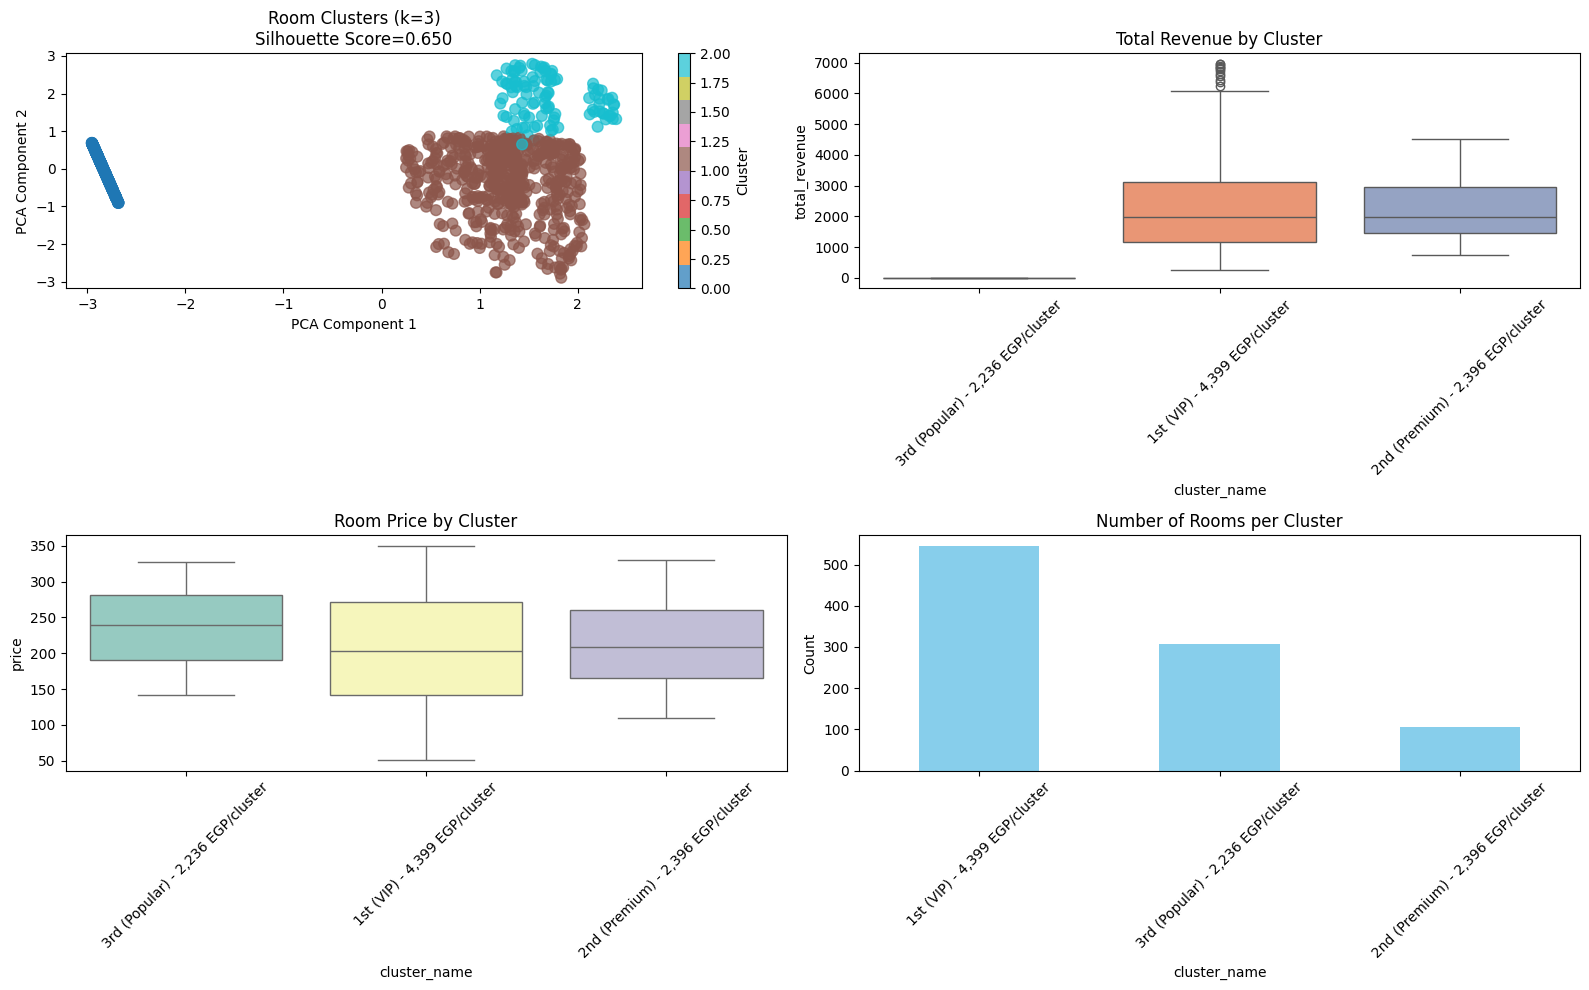

In [10]:
# --------------------------- 10. Visualizations ------------------------------
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_clean['cluster'], cmap='tab10', alpha=0.7, s=60)
plt.title(f'Room Clusters (k={best_k})\nSilhouette Score={best_score:.3f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label="Cluster")

plt.subplot(2,2,2)
sns.boxplot(data=df_clean, x='cluster_name', y='total_revenue', palette='Set2')
plt.title('Total Revenue by Cluster')
plt.xticks(rotation=45)

plt.subplot(2,2,3)
sns.boxplot(data=df_clean, x='cluster_name', y='price', palette='Set3')
plt.title('Room Price by Cluster')
plt.xticks(rotation=45)

plt.subplot(2,2,4)
df_clean['cluster_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Rooms per Cluster')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("ROOM_CLUSTERS_HIGH_ACCURACY_PLOT.png", dpi=300, bbox_inches='tight')